## imports

In [53]:
%matplotlib inline
# core
import numpy as np
import pandas as pd
import scipy.stats
# visualization
import matplotlib.pyplot as plt 
import seaborn as sns # seaborn is now installed by default. https://docs.anaconda.com/anaconda/release-notes#id10

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

from sklearn import neighbors

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier # It is called ENSEMBLE method since we are using more than one classifier.
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from scipy import interp
from sklearn.preprocessing import StandardScaler
import itertools
from IPython.display import HTML, display
import matplotlib.patches as mpatches
df=pd.read_csv("train.csv")
d = {}

In [54]:
def show_scatter(col,y,title):
    plt.scatter(col, lables2floats(y), c=lables2floats(y), s=30, cmap = "bwr")
    plt.title(title)
    plt.xlabel('values')
    plt.scatter(col,[0.5]*len(col),c = lables2floats(y),s=500,alpha=0.05, cmap = "bwr")
    plt.yticks([])
    plt.ylim(-0.05, 1.05)
    blue_patch = mpatches.Patch(color='blue', label='Class_2')
    red_patch = mpatches.Patch(color='red', label='Class_6')
    plt.legend(handles=[blue_patch,red_patch],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [55]:
def standardize(X_train,X_validation):
    scaler = StandardScaler()  
    # fit only on training data
    scaler.fit(X_train)  
    X_norm_train = scaler.transform(X_train)  
    # apply same transformation to test data
    X_norm_validation = scaler.transform(X_validation) 
    return  X_norm_train, X_norm_validation

In [56]:
# Adopted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j],2)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

In [57]:
class DictTable(dict):
    # renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        html = ["<table>"]
        for key, value in sorted(self.items(), key=lambda x: x[1],reverse=True):
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(value))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [58]:
def evaluate_auc_roc(X,y,clf,n_splits=5,plot=False,standardize_data=False):
    cnf = np.zeros((2,2))
    if isinstance(X, pd.DataFrame): 
        X_np = X.as_matrix()
    else:
        X_np = X
    y_np = lables2floats(y)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    kfold = KFold(n_splits, shuffle = False)
    for train_index, validation_index in kfold.split(X_np):
        X_train, X_validation, y_train, y_validation = X_np[train_index], X_np[validation_index], y_np[train_index], y_np[validation_index]
        if standardize_data:
            X_train,X_validation = standardize(X_train,X_validation)
        probas_ = clf.fit(X_train, y_train).predict_proba(X_validation)
        fpr, tpr, thresholds = roc_curve(y_validation, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        cnf+=confusion_matrix(y_validation,clf.fit(X_train, y_train).predict(X_validation))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    if plot: 
        std_auc = np.std(aucs)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plot_confusion_matrix(cnf, classes=['class_6','class_2'],normalize=True)
        
        
    return mean_auc

## Preprocessing
Drop all records which doesn't belong to the 2 biggest classes

In [59]:
def find_largest_classes(df): 
    # return the name of the most commen targets
    df2=df.groupby("target").size()
    num_of_colms=list(df2.sort_values()[-2:].keys())
    return num_of_colms

def filter_classes(df):
    # return the data frame only with the common classes
    num_of_classes=find_largest_classes(df)
    print num_of_classes[0]
    df2=df[(df.target==num_of_classes[0]) | (df.target==num_of_classes[1])]
    return df2

def lables2floats(y):
    # maps: Class_2 => 0, Class_6 => 1 needed for colormaps which accept floats 
    d = {'Class_2':0.0,'Class_6':1.0}
    return np.array([d[i] for i in y])

In [60]:
filtered_data = filter_classes(df)
data = filtered_data
grouped = data.groupby('target')
X,y = data[data.columns[:-1]],data[data.columns[-1]]

Class_6


## data visualization

In [61]:
grouped.describe(include = 'all')

feat_12       feat_20       feat_21       feat_23  \
target                                                                  
Class_2 count  12059.000000  12059.000000  12059.000000  12059.000000   
        mean       0.091716      0.126710      0.169085      0.028609   
        std        0.337387      0.466171      0.569606      0.238716   
        min        0.000000      0.000000      0.000000      0.000000   
        25%        0.000000      0.000000      0.000000      0.000000   
        50%        0.000000      0.000000      0.000000      0.000000   
        75%        0.000000      0.000000      0.000000      0.000000   
        max        5.000000      9.000000      8.000000      6.000000   
Class_6 count  10660.000000  10660.000000  10660.000000  10660.000000   
        mean       0.171482      0.345497      0.461069      0.137711   
        std        0.540553      0.904406      1.074871      0.627559   
        min        0.000000      0.000000      0.000000      0.000000   
        25%        0.000000      0.000000      0.000000      0.000000   
        50%        0.000000      0.000000      0.000000      0.000000   
        75%        0.000000      0.000000      0.000000      0.000000   
        max       12.000000     13.000000     13.000000     15.000000   

                    feat_51       feat_56       feat_61       feat_69  \
target                                                                  
Class_2 count  12059.000000  12059.000000  12059.000000  12059.000000   
        mean       0.002239      0.118915      0.012190      0.056555   
        std        0.059675      0.933050      0.131089      0.363064   
        min        0.000000      0.000000      0.000000      0.000000   
        25%        0.000000      0.000000      0.000000      0.000000   
        50%        0.000000      0.000000      0.000000      0.000000   
        75%        0.000000      0.000000      0.000000      0.000000   
        max        3.000000     42.000000      3.000000     17.000000   
Class_6 count  10660.000000  10660.000000  10660.000000  10660.000000   
        mean       0.122420      0.243152      0.956473      0.183583   
        std        0.848570      0.740943      1.884253      0.771583   
        min        0.000000      0.000000      0.000000      0.000000   
        25%        0.000000      0.000000      0.000000      0.000000   
        50%        0.000000      0.000000      0.000000      0.000000   
        75%        0.000000      0.000000      1.000000      0.000000   
        max       44.000000     20.000000     33.000000     21.000000   

                     feat_7       feat_70  
target                                     
Class_2 count  12059.000000  12059.000000  
        mean       0.020483      0.762584  
        std        0.177976      1.719298  
        min        0.000000      0.000000  
        25%        0.000000      0.000000  
        50%        0.000000      0.000000  
        75%        0.000000      1.000000  
        max        9.000000     32.000000  
Class_6 count  10660.000000  10660.000000  
        mean       0.114728      0.584240  
        std        0.448145      1.358014  
        min        0.000000      0.000000  
        25%        0.000000      0.000000  
        50%        0.000000      0.000000  
        75%        0.000000      1.000000  
        max        9.000000     25.000000

### scatter of features

To visualize the scatter of the features we created the following plot.
This plot represents 2 characteristics of each feature simultaneously:
1. Class - by it's color
2. Density - the more transparent the less samples taken from this region. the small dots helps to see the transparent samples.
These characteristics helps to find Regions Of Interest (ROI), the purer - the better!

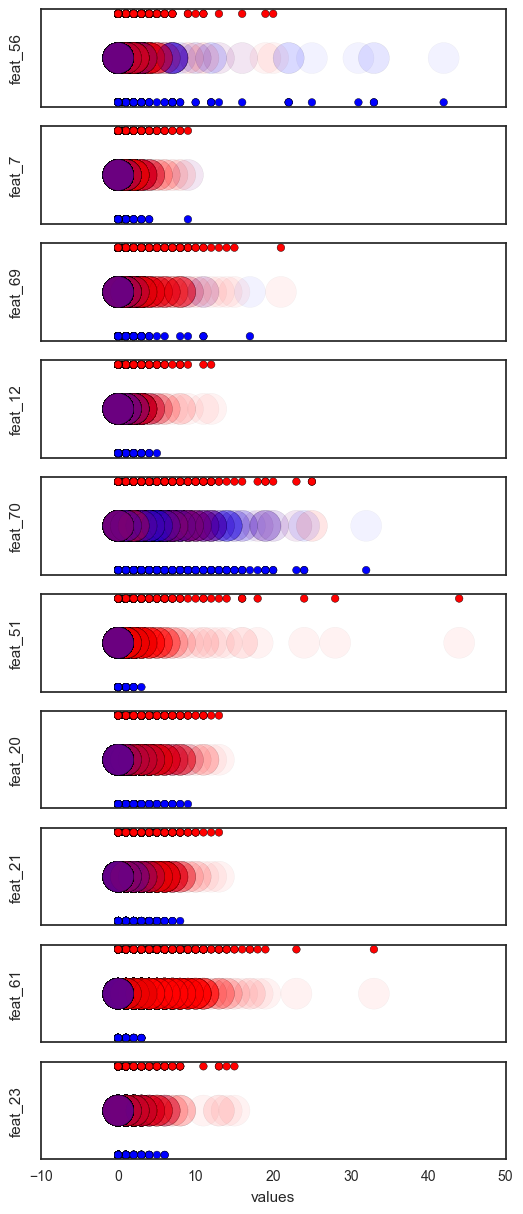

In [62]:
f, axarr = plt.subplots(10, sharex=True) 
tmp = 0
for feature in X:
    axarr[tmp].scatter(data[feature], lables2floats(y), c=lables2floats(y), s=30, cmap = "bwr")
    axarr[tmp].scatter(data[feature],[0.5]*len(data),c = lables2floats(y),s=500,alpha=0.05, cmap = "bwr")
    axarr[tmp].set_yticklabels([]) # clear y-axis because it meanningless 
    axarr[tmp].set_ylabel(feature) # set y-label to relevant feature
    axarr[tmp].set_ylim(-0.05, 1.05) # to place the small dots near the border 
    tmp+=1
    
plt.xlabel('values')
plt.subplots_adjust(top = 3)
plt.show()

### correlation of features

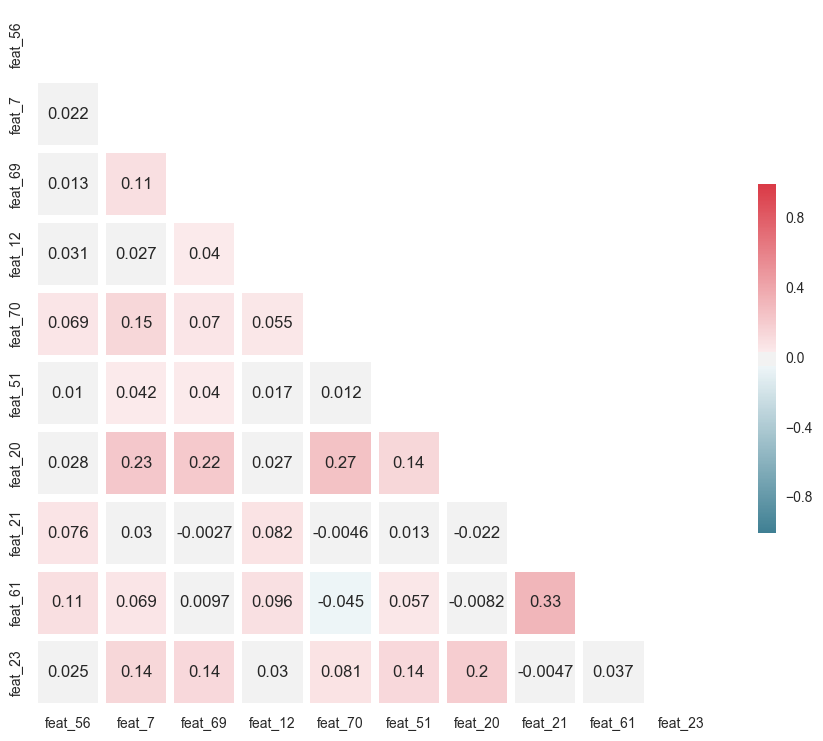

In [63]:
sns.set(style="white")
corr = X.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,annot=True, linewidths=5, cbar_kws={"shrink": 0.5})

for better understanding of the correlation we are using violinplot. At first it may look confusing but this plot contain a lot of information about the relation between diffrent features. The dot in the heart of the violin is the mean correlation of the given feature.

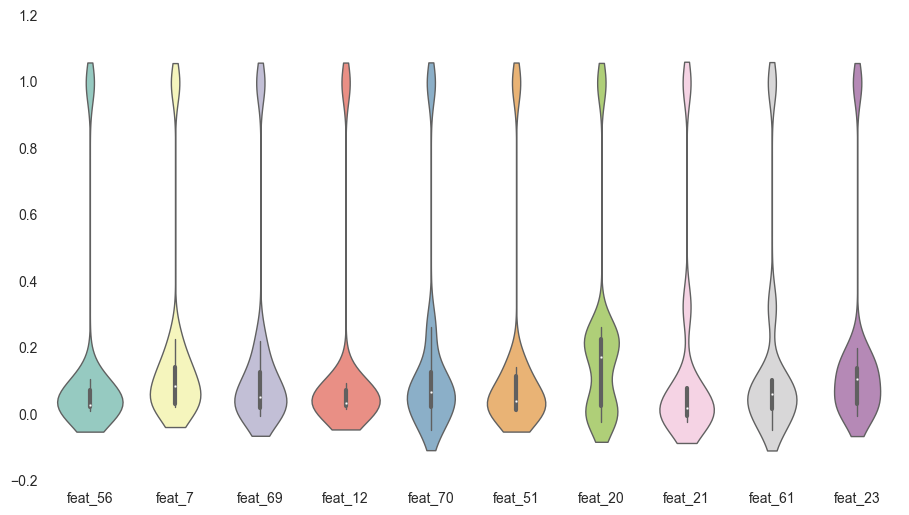

In [64]:
 
sns.set(style="white")
corr = X.corr()
corr_df = X.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=corr_df, palette="Set3", bw=.2, cut=1, linewidth=1)

# Finalize the figure
sns.despine(left=True, bottom=True)

## Feature generation

Let's use our observations on the features to engineer a powerful feature. 
We will use PCA and LDA later, so now we will focus on nonlinear combinations of features that cannot be generated with these methods.
Our scatter plots reveals that feature 51 and 61 have potential to be powerful together because they both have many dense "blue" points near zero, bounded on 3 and have relatively small correlation. So taking the maximum looks promising. 

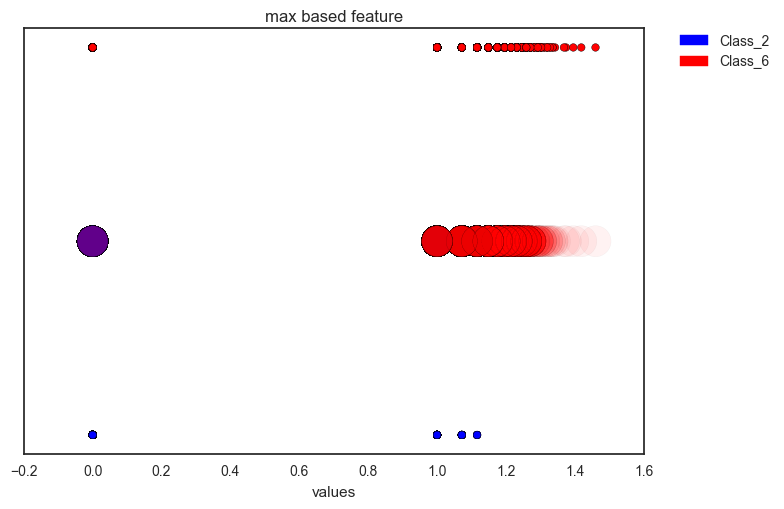

In [65]:
max_col = data[["feat_51", "feat_61"]].max(axis=1)**0.1
show_scatter(max_col,y,"max based feature")

To evaluate our feature we will use "round" as a classifier:

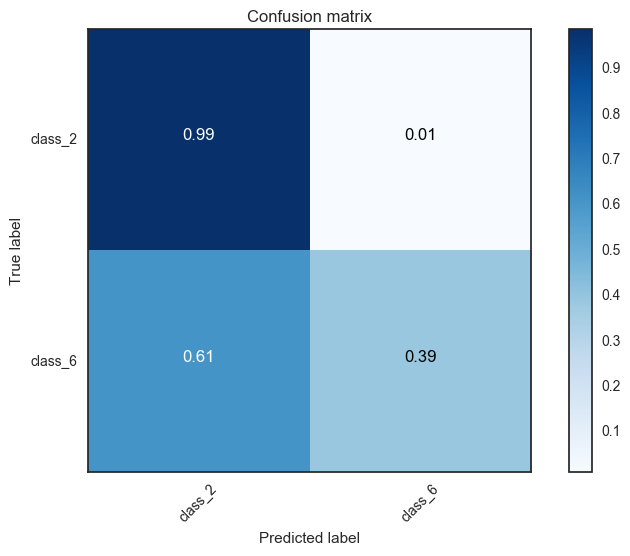

In [66]:
plot_confusion_matrix(confusion_matrix(lables2floats(y),np.round(max_col)), classes=['class_2','class_6'],normalize=True)

## Explorer Dimensionally Reduction

### LDA

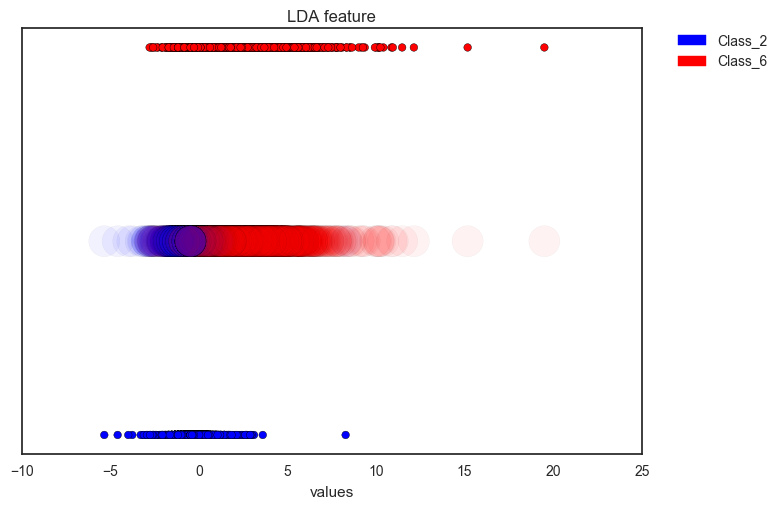

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis(n_components=2)
LDA.fit(X, y)
reduced_data = LDA.transform(X)
show_scatter(reduced_data[:, :],y,"LDA feature")


### PCA

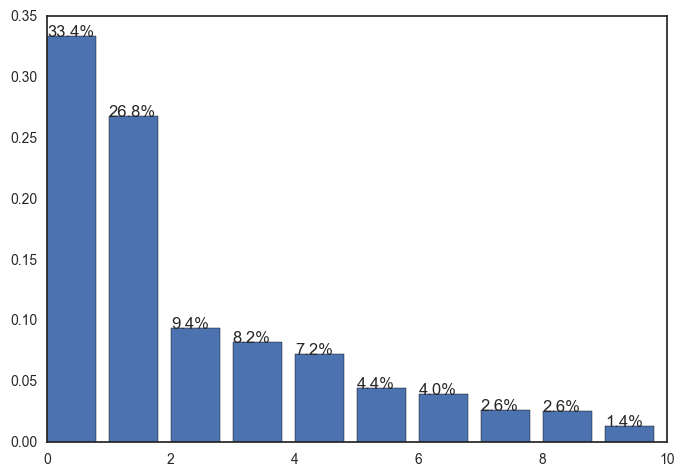

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)
plt.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
for a,b in zip(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_):
    plt.text(a, b, str(np.round(b,3)*100)+"%")
plt.show()

In [69]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

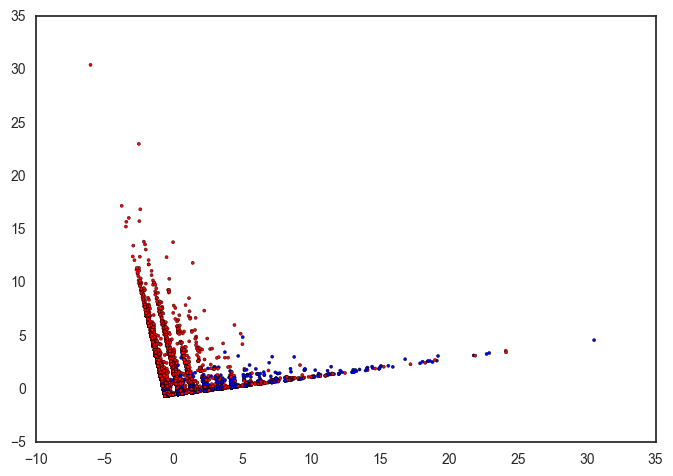

In [70]:
plt.scatter(X_r[:,0], X_r[:,1], s= 5, c=lables2floats(y), cmap = "bwr")
plt.show()

#### Pca after rotation
The structure of the PCA looks intresting, resambling some kind of a barplot..
However unfortunatly some models won't be able to detect and take adventage of this pattern.
We will assume Rotational invariance and rotate the data:

In [71]:
theta = np.radians(11)
c, s = np.cos(theta), np.sin(theta)
R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
X_r2 = np.array(X_r * R)


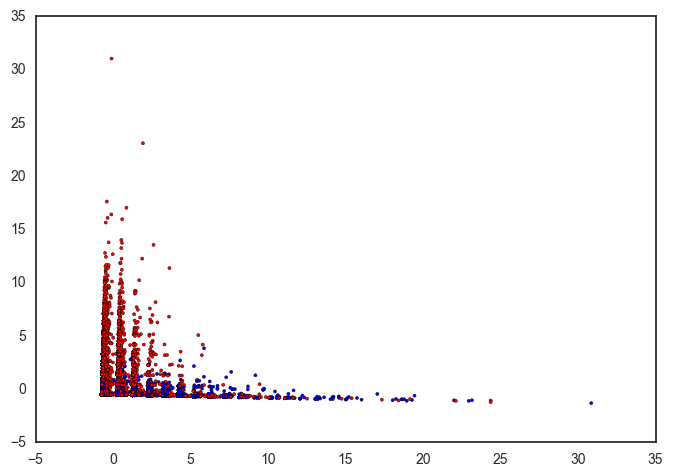

In [72]:
plt.scatter(X_r2[:,0], X_r2[:,1], s= 5, c=lables2floats(y), cmap = "bwr")
plt.show()

In [73]:

distances = ["euclidean","manhattan","chebyshev"]
distances_d = {}
for distance in distances:
    clf=neighbors.KNeighborsClassifier(n_neighbors=5, metric=distance)
    distances_d["regular PCA " + distance] = evaluate_auc_roc(X_r,y,clf)
    distances_d["rotated PCA "+ distance] = evaluate_auc_roc(X_r2,y,clf)
DictTable(distances_d)

rotated PCA euclidean,0.732431487342
rotated PCA manhattan,0.731838224516
rotated PCA chebyshev,0.731650420023
regular PCA euclidean,0.726880849265
regular PCA manhattan,0.72658902213
regular PCA chebyshev,0.726113325554


**Note that the "rotated" models got better AUC in all distances!**

## Trainning sets
At this section we will generate a list of diffrent trainning sets from the last part: 

In [74]:
combination_lst=[]
combination_lst_names=[]

In the next block we will add the training data as a benchmark for all engineered trainning sets. 

In [75]:
combination_lst_names.append("All training data")
combination_lst.append(X)

 We know that the performance of Naive Bayes can degrade if the data contains highly correlated features.
 In the next block we will remove the most correlated feature. 

In [76]:
combination_lst_names.append("without most correlated")
x_without_cor = X.drop(X.columns[np.array(X.corr().abs().sum()).argmax()],1)
combination_lst.append(x_without_cor)

Next we will enrich the original training set with two different strong features, the LDA and our "max column" feature.
We chose to do it because they both very dense around zero so they weak in that domain. Adding more dimensions may help.   

In [77]:
combination_lst_names.append("all with max col")
all_with_maxcol = X.assign(e=max_col).values
combination_lst.append(all_with_maxcol)

combination_lst_names.append("all with LDA")
all_with_LDA = X.assign(e=reduced_data).values
combination_lst.append(all_with_LDA)

# K-Nearest Neighbour with All combinations

In [78]:
def knn(relevent_X,plot=False): 
    # creating odd list of K for KNN
    neighbors = list(range(1,15,2)) # subsetting just the odd ones
    
    # empty list that will hold cv scores
    cv_auc = []

    # we will use k-fold cross validation and will perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,metric="euclidean") #calculate knn for k neighbors
        cv_auc.append(evaluate_auc_roc(relevent_X,y,knn)) #list of mean auc for each folder with the relevt data.
    # changing to misclassification error
    # determining best k
    optimal_k = neighbors[cv_auc.index(max(cv_auc))]
    #from sklearn import neighbors, datasets
    clf = KNeighborsClassifier(n_neighbors=optimal_k, 
                                         weights="uniform",
                                        metric="euclidean",
                                        algorithm= "brute")
    clf.fit(relevent_X, y)
    if plot:
        plt.plot(neighbors,cv_auc,linestyle='--', marker='o')
        plt.xlabel('Number of Neighbors K')
        plt.ylabel('Auc')
        plt.show()
        print "The optimal number of neighbors is %d" % optimal_k  
        return 
    return evaluate_auc_roc(relevent_X,y,clf),optimal_k

In [79]:
def Best_combination(combination_lst): 
    max_index=0
    n=len(combination_lst)
    auc_lst=[]
    k_optimal_lst=[]
    for i in range(n):
        clf=knn(combination_lst[i])
        auc_lst.append(clf[0])
        k_optimal_lst.append(clf[1])
    return np.array(auc_lst).argmax(),auc_lst,k_optimal_lst


We get the maximun score when we use knn with data that include all with LDA. The score that we get in that case is 0.771593201492


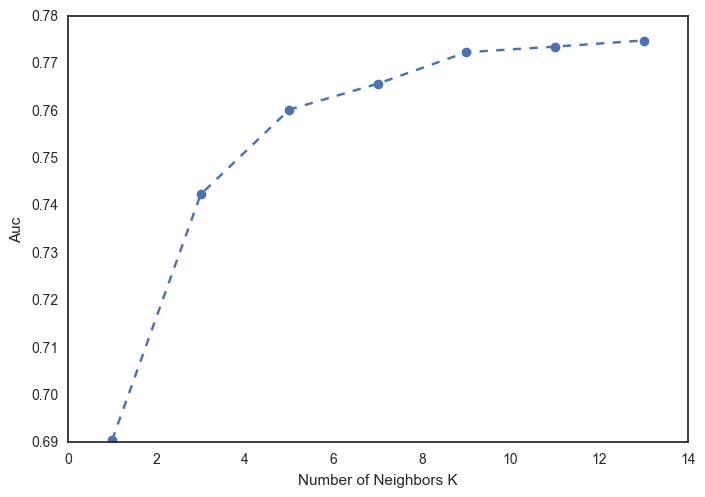

The optimal number of neighbors is 13


In [80]:
max_index,auc_lst,k_optimal_lst= Best_combination(combination_lst)
knn_d = {}
for i in range(len(auc_lst)):
    knn_d[combination_lst_names[i]] = auc_lst[i]
print "We get the maximun score when we use knn with data that include "+combination_lst_names[max_index] + ". The score that we get in that case is "+ str(auc_lst[max_index])
knn(combination_lst[max_index],plot=True)

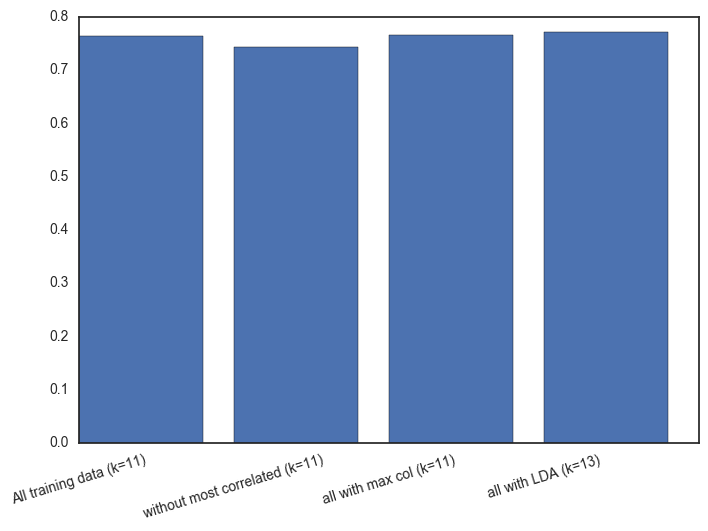

In [81]:
x = np.arange(len(combination_lst_names))
plt.bar(x,auc_lst)
plt.xticks(x,[combination_lst_names[i]+" (k="+str(k_optimal_lst[i])+")" for i in range(len(combination_lst_names))],rotation=17)
plt.show()

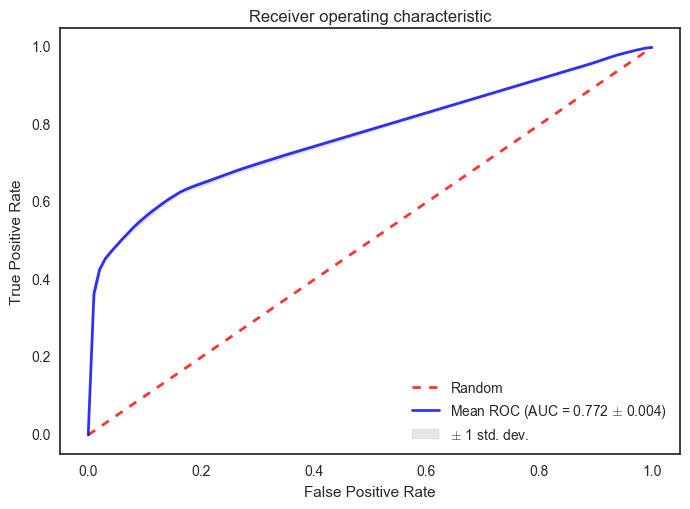

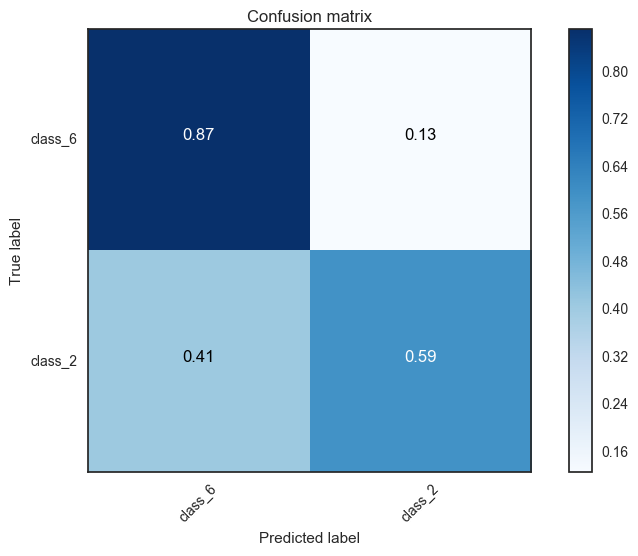

In [82]:
clf = KNeighborsClassifier(n_neighbors=k_optimal_lst[max_index], 
                           weights="uniform",
                           metric="euclidean",
                           algorithm= "brute")
d["KNN"] = evaluate_auc_roc(combination_lst[max_index],y,clf,plot=True)

## Naive

In [83]:
# https://machinelearningmastery.com/better-naive-bayes/
clf = GaussianNB()
Naive_auc = [evaluate_auc_roc(comb,y,clf,n_splits=5) for comb in combination_lst]

All training data has the highest AUC: 0.763251358373


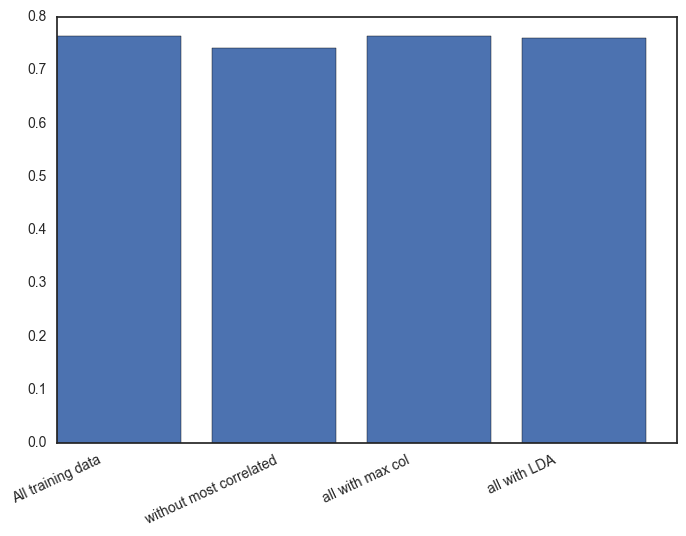

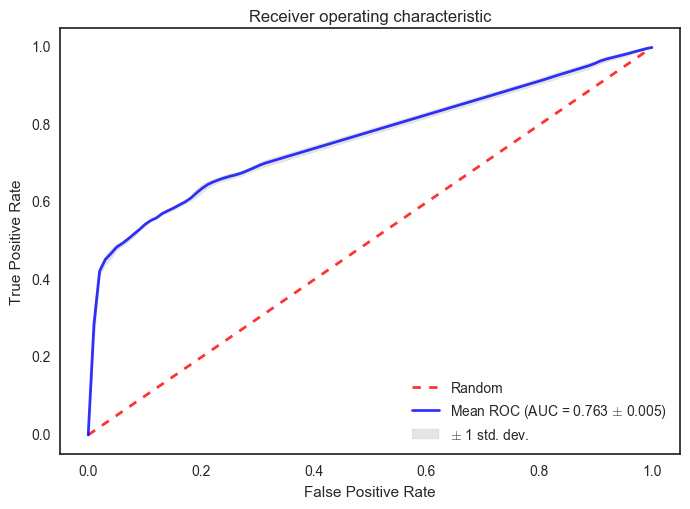

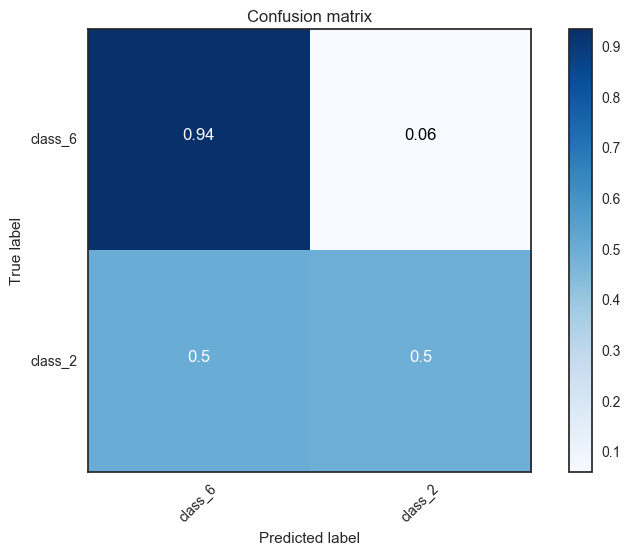

In [84]:
print(str(combination_lst_names[np.array(Naive_auc).argmax()])+" has the highest AUC: "+str(max(Naive_auc)))
x = np.arange(len(combination_lst_names))
plt.bar(x, Naive_auc) # TODO: sort
plt.xticks(x, combination_lst_names,rotation=25)
plt.show()
d["Naive"] = evaluate_auc_roc(combination_lst[np.array(Naive_auc).argmax()],y,clf,n_splits=5,plot=True)

## MLP

In [85]:
clf = MLPClassifier(#-----The architecture:------#
                    activation="tanh", #What is the activation function between neurons {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}?
                    hidden_layer_sizes= (50,100,20),  #What is the architecture? what happens if we add more layers?
                    alpha = 0.00001, #The regularization: loss + alpha*W^2
                    batch_size = "auto",#when set to auto,batch zise= min(200,n_samples)
                    #-----The optimizer:------#
                    solver = "sgd", #Stochastic Gradient Descent, other optimizers are out of the scope of the course.
                    learning_rate = "adaptive", #How does the learning rate update itself? {‘constant’, ‘invscaling’, ‘adaptive’}
                    learning_rate_init = 0.5, #What is the initial learning rate? in some optimizers the learning rate changes.
                    power_t = 0.5, #When we choose learning rate to be invscaling, it means that we multiply this number each epoch.
                    momentum = 0.9, #Whats the fraction of the updated dedicated to the momentum? the "friction".
                    nesterovs_momentum = False, #Out of the scope of the course, leave false.
                    early_stopping = False, #Do we set a validation data aside?
                    tol = 1e-4, #A broad concept of converges, when we can say the algorithm converged?
                    warm_start = True, #if we fit at the second time, do we start from the last fit?
                    max_iter = 10000)


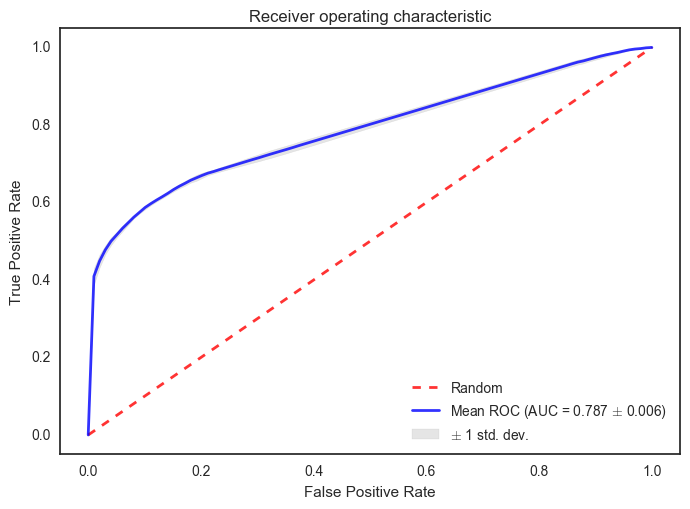

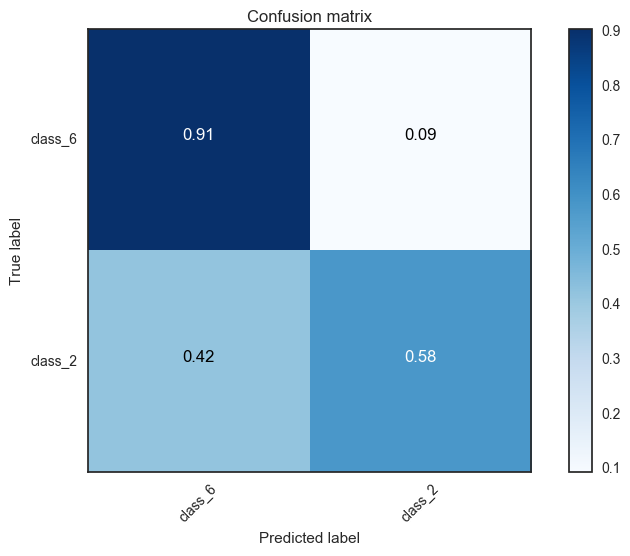

In [86]:
d["MLP"] = evaluate_auc_roc(X,y,clf,n_splits=5,plot=True)

#### normlize features

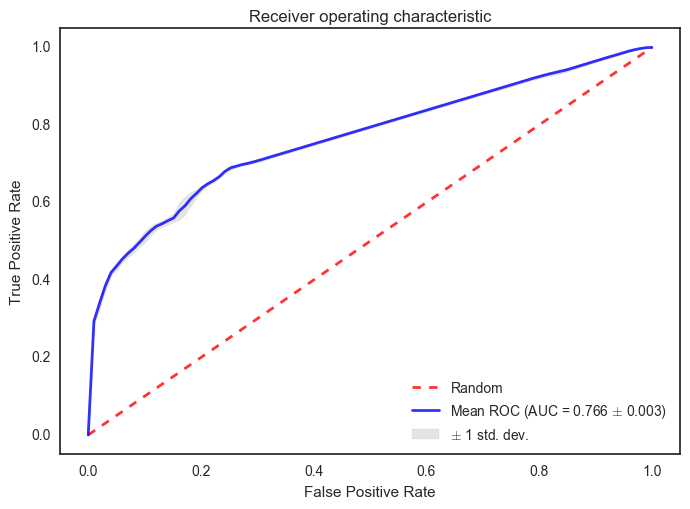

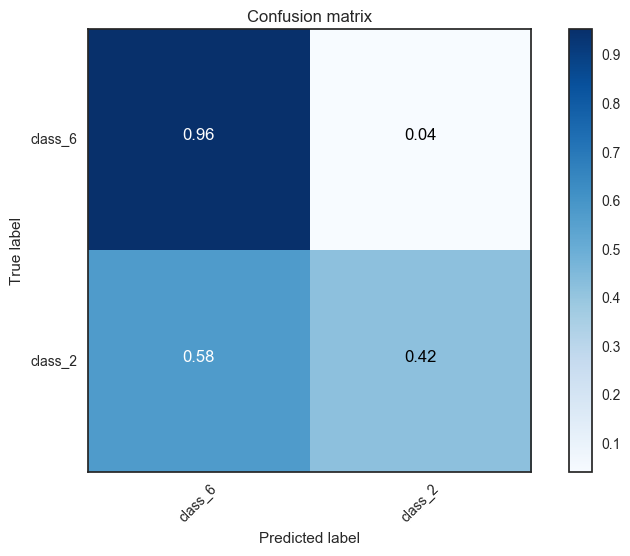

In [87]:
d["MLP normlized"] = evaluate_auc_roc(X,y,clf,n_splits=5,plot=True,standardize_data=True)

### Random Forest Classifier

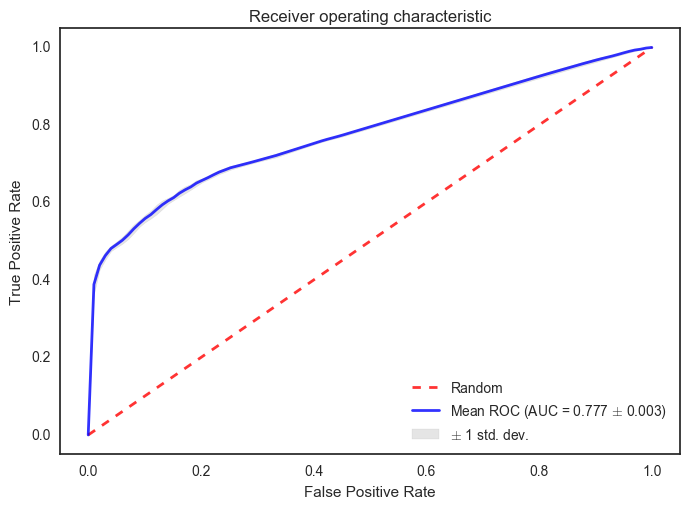

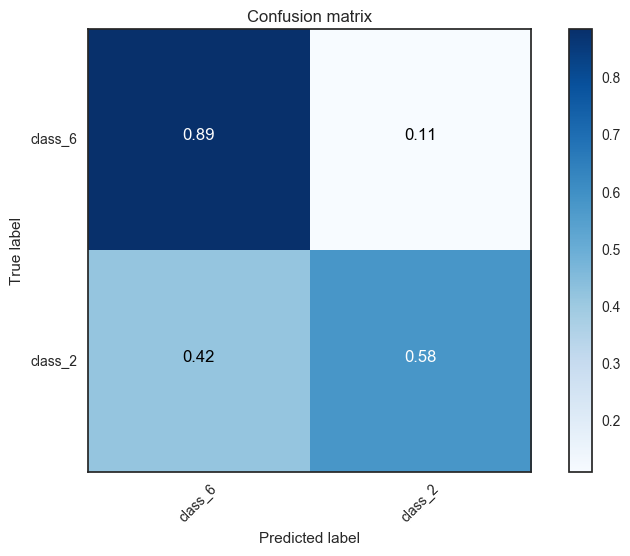

In [88]:
bdt_dt = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(min_samples_split=5,max_depth=5), n_estimators=364,algorithm = "SAMME") # 
d["bdt_dt"] = evaluate_auc_roc(X,y,bdt_dt,n_splits=5,plot=True)

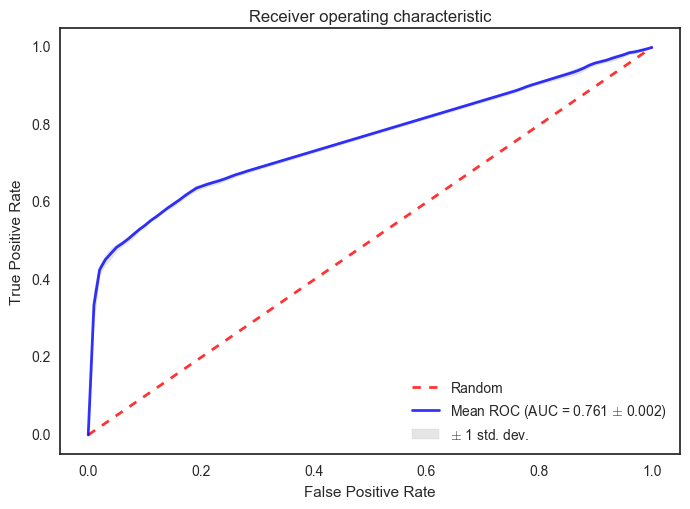

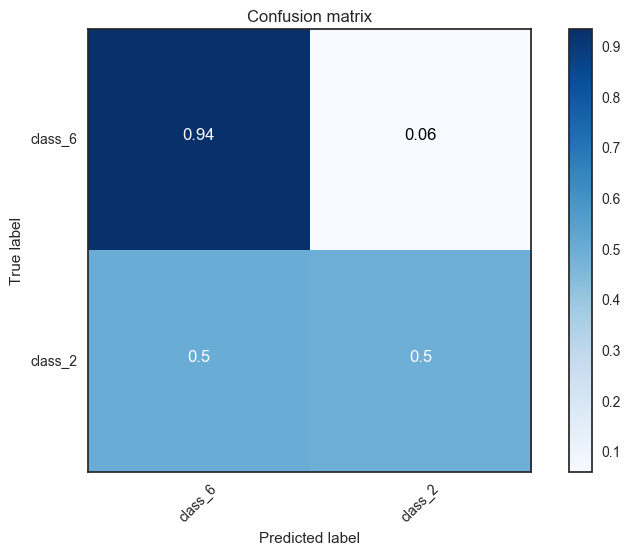

In [89]:
bdt_gnb = AdaBoostClassifier(base_estimator= GaussianNB(), n_estimators=364,algorithm = "SAMME")
d["bdt_gnb"] = evaluate_auc_roc(X,y,bdt_gnb,n_splits=5,plot=True)

lets visualize that classifier with PCA and rotated pca and check the results..

In [90]:
def plot_decision_bounderies(stage,X_r):
    plot_step = 0.1
    bdt = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(min_samples_split=5,max_depth=5), n_estimators=1000,algorithm = "SAMME") # 
    bdt.fit(X_r, lables2floats(y)) # split to train/test?!
    print("AUC: "+str(evaluate_auc_roc(pd.DataFrame(X_r),y,bdt_gnb,n_splits=5,plot=False)))
    plt.figure(figsize=(10, 10))
    
    x_min, x_max = X_r[:, 0].min() - 1, X_r[:, 0].max() + 1
    y_min, y_max = X_r[:, 1].min() - 1, X_r[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    
    # If we don't give a stage parameter, the computer will plot the decision boundaries of the ensemble.
    if stage==None:
        Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])


    #Given a specific stage, the decision boundaries that will be shown are the boundaries of the estimatior No. stage.
    else:
        Z= bdt.estimators_[stage].predict(np.c_[xx.ravel(), yy.ravel()])
        
    Z =Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z,cmap="seismic") #Plotting the decision boundaries of the base estimator at stage i/the boosted, 

    plt.scatter(X_r[:,0], X_r[:,1], c=lables2floats(y),s=1.6, cmap = "bwr")
    
    plt.xlabel('X0')
    plt.ylabel('X1')
    plt.title('Decision Boundary')
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35)
    plt.show()

AUC: 0.639452194443


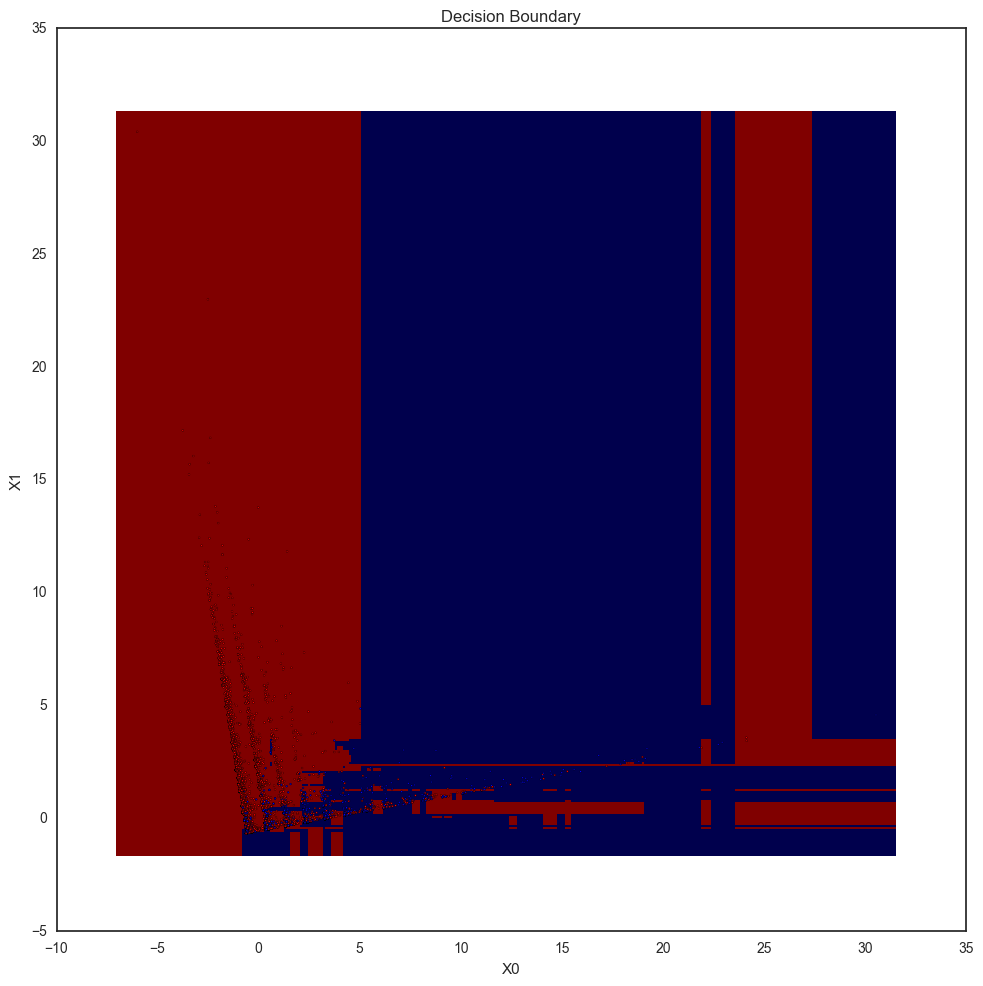

In [91]:
plot_decision_bounderies(None,X_r)

#### with rotation

AUC: 0.677713747982


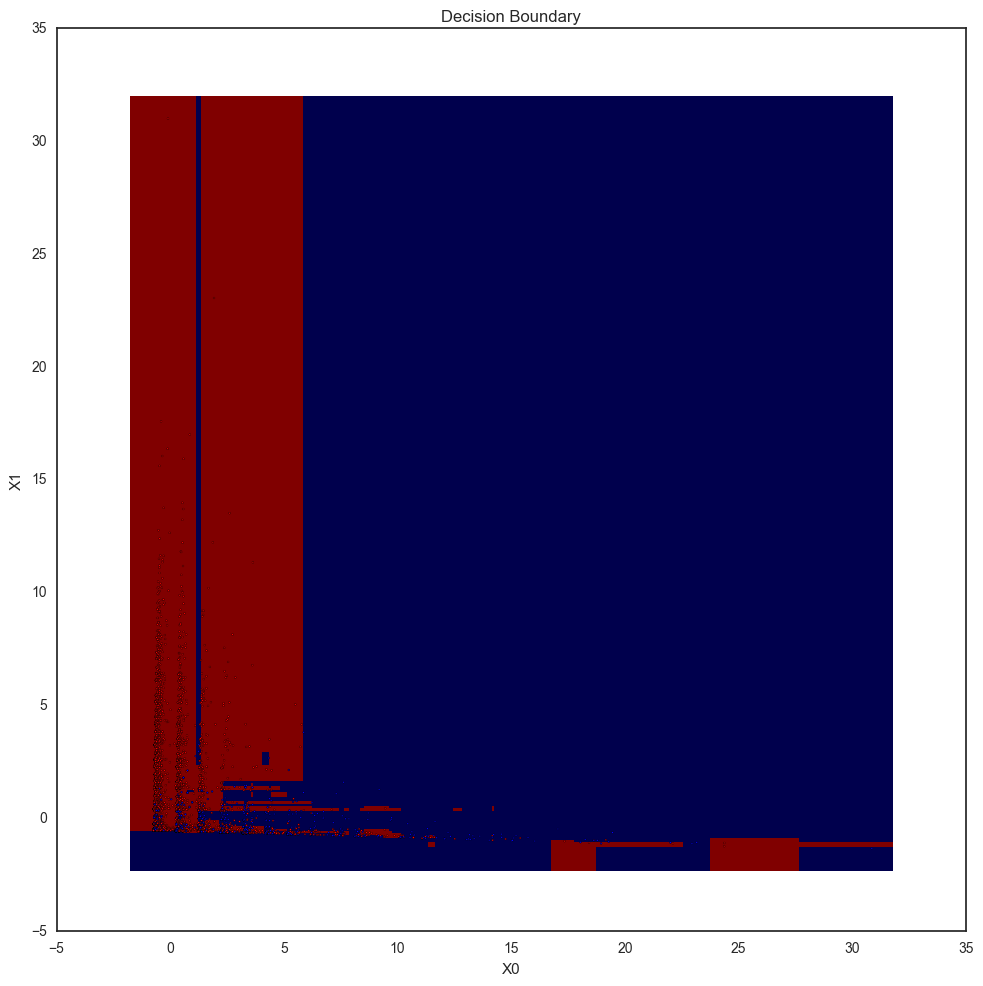

In [92]:
plot_decision_bounderies(None,X_r2)

** Again the rotation gives better AUC**

## summary 
Here is a summary of all the models we used:

In [93]:
DictTable(d)

MLP,0.786811064478
bdt_dt,0.777416277694
KNN,0.771593201492
MLP normlized,0.766007956416
Naive,0.763251358373
bdt_gnb,0.760883405731
